In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

np.random.seed(2)

Using TensorFlow backend.


In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
print(train.shape) #(42000, 785)
print(test.shape) #(28000, 784)
# train.head()

(42000, 785)
(28000, 784)


(42000, 784) (42000,)


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

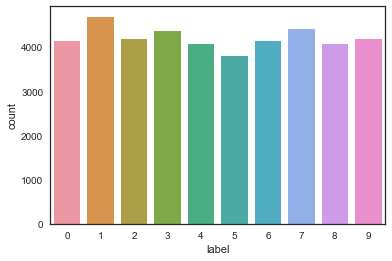

In [3]:
X_train = train.drop('label', axis=1)
Y_train = train['label']
print(X_train.shape, Y_train.shape)
g = sns.countplot(Y_train)
Y_train.value_counts()

In [4]:
print(X_train.isnull().any().sum())
print(test.isnull().any().sum())

0
0


In [5]:
#Confit
num_classes = 10
random_seed = 2
epochs = 30 
batch_size = 56
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'kevin.h5py'

#第一次執行忽略下列兩行
# model_path = os.path.join(save_dir, model_name)
# model = load_model(model_path)

In [6]:
#Normalize
X_train = X_train/255
test = test/255

#Reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

#one hat encoding
Y_train = to_categorical(Y_train, num_classes = num_classes)

#split train,valication set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=random_seed)

print(X_train.shape, X_val.shape, Y_train.shape)

(33600, 28, 28, 1) (8400, 28, 28, 1) (33600, 10)


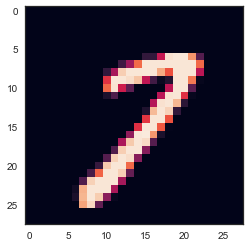

In [7]:
g = plt.imshow(X_train[18][:,:,0])

In [8]:
#CNN Model
# [conv2d *2 + maxpoll2d + dropout]*2 + Flatten + Dense + dropout + out
model = Sequential()

# model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu', input_shape = (28,28,1)))
# model.add(Conv2D(filters = 16, kernel_size=(3,3), padding='Same', 
#                  activation = 'relu', input_shape = (28,28,1)))
# model.add(MaxPool2D(pool_size=(2,2),strides=(1,1)))
# model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size=(3,3), padding='Same', 
                 activation = 'relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2),strides=(1,1)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 64, kernel_size=(3,3), padding='Same', 
                 activation = 'relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2),strides=(1,1)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

print(model.summary())

In [9]:
#Optimizer
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',  #val_loss
                                            factor=0.5, 
                                            patience=5, 
                                            verbose=1, 
                                            mode='auto', 
                                            epsilon=0.0001, 
                                            cooldown=0, 
                                            min_lr=0.0001)


In [10]:
#Data augmentation
# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.2, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=False,  # randomly flip images
#         vertical_flip=False)  # randomly flip images
datagen = ImageDataGenerator(
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

In [11]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
datagen.fit(X_train)

#Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])


# Plot the loss and accuracy curves for training and validation 
# fig, ax = plt.subplots(2,1)
# ax[0].plot(history.history['loss'], color='b', label="Training loss")
# ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
# legend = ax[0].legend(loc='best', shadow=True)

# ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
# ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
# legend = ax[1].legend(loc='best', shadow=True)

Epoch 1/30
 - 417s - loss: 0.4798 - acc: 0.8474 - val_loss: 0.0806 - val_acc: 0.9760
Epoch 2/30
 - 415s - loss: 0.1984 - acc: 0.9417 - val_loss: 0.0593 - val_acc: 0.9820
Epoch 3/30
 - 415s - loss: 0.1566 - acc: 0.9553 - val_loss: 0.0536 - val_acc: 0.9838
Epoch 4/30
 - 416s - loss: 0.1369 - acc: 0.9602 - val_loss: 0.0514 - val_acc: 0.9848
Epoch 5/30
 - 436s - loss: 0.1196 - acc: 0.9641 - val_loss: 0.0448 - val_acc: 0.9864
Epoch 6/30
 - 472s - loss: 0.1109 - acc: 0.9673 - val_loss: 0.0445 - val_acc: 0.9869
Epoch 7/30
 - 435s - loss: 0.1112 - acc: 0.9665 - val_loss: 0.0451 - val_acc: 0.9880
Epoch 8/30
 - 436s - loss: 0.1030 - acc: 0.9701 - val_loss: 0.0426 - val_acc: 0.9879
Epoch 9/30
 - 437s - loss: 0.0974 - acc: 0.9710 - val_loss: 0.0423 - val_acc: 0.9875
Epoch 10/30
 - 436s - loss: 0.0979 - acc: 0.9715 - val_loss: 0.0354 - val_acc: 0.9894
Epoch 11/30
 - 436s - loss: 0.0877 - acc: 0.9740 - val_loss: 0.0317 - val_acc: 0.9905
Epoch 12/30
 - 434s - loss: 0.0927 - acc: 0.9745 - val_loss: 0.

NameError: name 'load_model' is not defined

In [12]:
#第一次執行忽略下列兩行
# model_path = os.path.join(save_dir, model_name)
# model = load_model(model_path)

# loading our save model
print("Loading trained model")
model = load_model(model_path)

# Score trained model.
scores = model.evaluate(X_val, Y_val, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

Loading trained model


NameError: name 'load_model' is not defined

In [14]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("digit.csv",index=False)